# Moment maps of line emission
This is a notebook to project 3D line emission cubes from SIGAME to moment0 maps. 

Author: Jay Motka
Supervisor: Karen P. Olsen

---

### Moment0 map
You can read about moment maps in astronomy here: 

https://www.cfa.harvard.edu/rtdc/CO/MomentMasking/

In [1]:
### Import the modules we will need
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.spatial import cKDTree
import time
fontsize = 15
mpl.rcParams['ytick.labelsize'] = fontsize # increase label size in plots
mpl.rcParams['xtick.labelsize'] = fontsize # increase label size in plots

In [2]:
### First we import the 3D datacube with line emission per cell:
datacube      =    pd.read_pickle('z0.00_fG106.cell_data')

In [3]:
### Take a look at the first 5 rows in of the datacube:
datacube.head()

,x,y,z,n_dust,cell_size,cell_volume,rho,m,mH,nH,...,L_[CI]370,L_[OI]145,L_[OI]63,L_[OIII]88,L_[NII]122,L_[NII]205,L_CO(3-2),L_CO(2-1),L_CO(1-0),NH
0,-58.651875,-58.651875,-58.651875,4.918675e-12,7.82025,4.782576e+11,0.011191,5.434260,4.075695,3.394788e-10,...,8.472793e-12,0.000001,0.000011,0.000003,8.748788e-07,0.000004,9.057820e-75,3.637962e-75,1.819548e-76,8.683966e+20
1,-50.831625,-58.651875,-58.651875,2.951480e-11,7.82025,4.782576e+11,0.291045,141.334394,106.000796,8.829175e-09,...,2.513781e-10,0.000030,0.000315,0.000046,2.164689e-05,0.000096,9.072941e-71,4.774382e-71,2.866297e-72,7.923468e+20
2,-58.651875,-50.831625,-58.651875,1.010612e-10,7.82025,4.782576e+11,1.925991,935.282244,701.461683,5.842719e-08,...,1.307849e-09,0.000150,0.001561,0.000431,1.298560e-04,0.000597,1.291200e-73,5.105813e-74,2.546406e-75,8.654706e+20
3,-50.831625,-50.831625,-58.651875,2.541077e-10,7.82025,4.782576e+11,6.913218,3357.134249,2517.850687,2.097206e-07,...,5.178948e-09,0.000582,0.006025,0.001062,4.426472e-04,0.001953,5.067243e-71,2.509378e-71,1.457220e-72,8.000914e+20
4,-58.651875,-58.651875,-50.831625,1.203988e-11,7.82025,4.782576e+11,0.061411,29.821967,22.366475,1.862982e-09,...,3.896506e-11,0.000004,0.000046,0.000015,3.983468e-06,0.000018,4.427859e-76,1.637064e-76,7.821515e-78,8.825912e+20


In [4]:
datacube.keys()

Index(['x', 'y', 'z', 'n_dust', 'cell_size', 'cell_volume', 'rho', 'm', 'mH',
       'nH', 'F_NIR_W_m2', 'F_FUV_W_m2', 'F_UV_W_m2', 'UV_to_FUV', 'R_NIR_FUV',
       'F_FUV_Habing', 'E_FUV_ergs_cm3', 'G0', 'SFR_density', 'Z', 'Mach',
       'cell_size_lookup', 'mf_1e3', 'mf_1e1', 'L_[CII]158', 'L_[CI]610',
       'L_[CI]370', 'L_[OI]145', 'L_[OI]63', 'L_[OIII]88', 'L_[NII]122',
       'L_[NII]205', 'L_CO(3-2)', 'L_CO(2-1)', 'L_CO(1-0)', 'NH'],
      dtype='object')

In [5]:
### Count number of cells
N_models = len(datacube)
print('%i cells found' % N_models)

656888 cells found


In [6]:
Z = datacube['Z']
Z[np.isnan(Z)] = 0
datacube['Z'] = Z

In [7]:
properties = np.column_stack((datacube.m, datacube.m * datacube.Z, datacube['L_[CII]158']/6, datacube['L_[CI]610']/6, datacube['L_[CI]370']/6, datacube['L_[OI]145']/6, datacube['L_[OI]63']/6, datacube['L_[OIII]88']/6, datacube['L_[NII]122']/6, datacube['L_[NII]205']/6, datacube['L_CO(3-2)']/6, datacube['L_CO(2-1)']/6, datacube['L_CO(1-0)']/6))

In [8]:
### data:
cellsize = datacube.cell_size  #kpc               #(Cell-sizes in kpc)                         
X = datacube.x                                    #(x-coordinates)
Y = datacube.y                                    #(y-coordinates)
Z = datacube.z                                    #(z-coordinates)

In [9]:
### minimum and maximum coordinates:
xmin, xmax = min(X), max(X)
ymin, ymax = min(Y), max(Y)
zmin, zmax = min(Z), max(Z)
xminindex, xmaxindex = np.where(X == xmin)[0][0], np.where(X == xmax)[0][0]
yminindex, ymaxindex = np.where(Y == ymin)[0][0], np.where(Y == ymax)[0][0]
zminindex, zmaxindex = np.where(Z == zmin)[0][0], np.where(Z == zmax)[0][0]
xmin, xmax, ymin, ymax, zmin, zmax

(-62.073234379999995,
 61.58446875,
 -62.073234379999995,
 62.073234379999995,
 -61.58446875,
 58.651875)

In [10]:
### luminosity_density in cell:
cellarea = cellsize * cellsize                        #kpc^2
area = np.column_stack((cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea, cellarea))
celldensity =  properties / area                      #units / kpc^2

In [11]:
plane = input('The plane that you want to project to (xy or yz or zx): ')

The plane that you want to project to (xy or yz or zx): xy


In [12]:
if plane == 'xy':
    axis1, min1, max1, minindex1, maxindex1 = X, xmin, xmax, xminindex, xmaxindex
    axis2, min2, max2, minindex2, maxindex2 = Y, ymin, ymax, yminindex, ymaxindex

elif plane == 'yz':
    axis1, min1, max1, minindex1, maxindex1 = Y, ymin, ymax, yminindex, ymaxindex
    axis2, min2, max2, minindex2, maxindex2 = Z, zmin, zmax, zminindex, zmaxindex
    
elif plane == 'zx':
    axis1, min1, max1, minindex1, maxindex1 = Z, zmin, zmax, zminindex, zmaxindex
    axis2, min2, max2, minindex2, maxindex2 = X, xmin, xmax, xminindex, xmaxindex

In [13]:
### cell setups: 
cellstart1 = axis1 - (cellsize / 2)
cellstart2 = axis2 - (cellsize / 2)
cellend1 = cellstart1 + cellsize
cellend2 = cellstart2 + cellsize

### Arrays containing index and x,y,z-coordinate details of each cell:
cell1 = np.column_stack([datacube.index, cellstart1, cellend1])
cell2 = np.column_stack([datacube.index, cellstart2, cellend2]) 

In [14]:
### size of the pixel:
PIXELSIZE = 0.5 # kpc in 1D

### KD-Tree:

The tool used is scipy's KD-Tree function which finds all k nearest neighbors to each point that you are interested in:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

In [15]:
tree = cKDTree(np.c_[axis1.ravel(), axis2.ravel()])

R is the maximum distance that any centre of cell can be from the centre of pixel. (0.1 is a correction to make sure no cells are left out.)

In [16]:
R = (max(cellsize)/(2**0.5)) + (PIXELSIZE/(2**0.5)) + 0.1

### Algorithm:

Note: Here we are completely ignoring the third coordinates (line of sight). By doing so, we reduce the datacube to a 2D-sheet where flattened 2D cells are stacked over one another. By doing so, we avoid the complexity of iterating over the third direction.  

1. Apply KD-Tree to centre-coordinates of the pixel to find any cells within the distance R.
2. Loop through these nearest neighbour cells of the given pixel.
3. In the loop, to find overlapping cells, we use the if statement stated in the code below.
   If statement: in 1 direction (let's say x), min from the ending edge of the squares is subtracted from the max of the
   startinging edge of the squares. If this substraction is lesser than 0 then the cell and pixel is overlapping in that            direction.
4. Inside the if statement, now that the overlapping is assured, we find the edge lengths of the overlapping rectangle.
   This is being done by subtracting coordinates of max from the starting edge of the squares from the min of the ending
   edge of the squares. 
5. Now we find the area of the overlapping rectangle and multiply it with the surface density (luminosity or mass) of the cell.
6. By repeating the loop through every cell, we add up all the luminosity due to overlap in that pixel.

Note: Theoretically, we are assuming the ISM to be transparent for this moment0 maps.

In [17]:
def line_luminosity(tree, cell1, cell2, pixel, celldensity, R):
    '''
    This function returns the total luminosity of the pixel using the algorithm shown above.
    '''
    
    # pixel-coordinates:
    pixelstart1 = pixel[0]
    pixelcentre1 = pixel[1]
    pixelend1 = pixel[2]
    pixelstart2 = pixel[3]
    pixelcentre2 = pixel[4]
    pixelend2 = pixel[5]
    
    # 1. Query_ball_point method of KDTree to find cells within distance R:
    ii = tree.query_ball_point([pixelcentre1, pixelcentre2], r=R)
    
    # appending coordinate values of the nearest cells gained by KD-Tree:
    ax1 = []
    ax2 = []
    for index in ii:
        ax1.append(cell1[index])
        ax2.append(cell2[index])
    
    # 2. For loop to go over each cell:
    lineluminosity = 0
    for i in range(len(ax1)):
        
        # 3. if statement to find whether the cell overlaps the pixel or not:
        if (max(pixelstart1, ax1[i][1]) - min(pixelend1, ax1[i][2]) < 0) and (max(pixelstart2, ax2[i][1]) - min(pixelend2, ax2[i][2]) < 0):
    
            # 4. Finding edge lengths of overlapping rectangle:
            edge1 = min(pixelend1, ax1[i][2])-max(pixelstart1,ax1[i][1])
            edge2 = min(pixelend2, ax2[i][2])-max(pixelstart2,ax2[i][1])
            
            # 5. Finding overlapping crosssection area and luminosity due to that overlpping cell:
            crosssection = edge1 * edge2
            pixelluminosity = crosssection * celldensity[int(ax1[i][0])]
            
            # 6. Adding up the luminosity due to each cell:
            lineluminosity += pixelluminosity

    return lineluminosity

Now we run two while loops inside each other to sum up luminosity of every pixel.

In [18]:
# While loop to go through axis2-direction:
index = 0
index2 = 0
momentmapdata = []
pixelstart2 = min2 - (cellsize[minindex2] / 2)
while pixelstart2 <= max2 + (cellsize[maxindex2] / 2): 
    pixelend2 = pixelstart2 + PIXELSIZE
    
    # While loop to go through axis1-direction:
    index1 = 0
    pixelstart1 = min1 - (cellsize[minindex1] / 2)
    while pixelstart1 <= max1 + (cellsize[maxindex1] / 2):
        pixelend1 = pixelstart1 + PIXELSIZE

        # central coordinates of each pixel-lines:
        pixelcentre1 = pixelstart1 + (PIXELSIZE/2)
        pixelcentre2 = pixelstart2 + (PIXELSIZE/2)
        
        # Pixel coordinates:
        pixel = [pixelstart1, pixelcentre1, pixelend1, pixelstart2, pixelcentre2, pixelend2]
        
        # Calling line_luminosity function for the particular pixel: 
        lineluminosity = line_luminosity(tree, cell1, cell2, pixel, celldensity, R)
        
        if np.sum(lineluminosity) > 0:
                pass
        else:
            lineluminosity = np.zeros(len(properties[0]))

        # Appending data of each pixelline for 2D projection:
        momentmapdata.append([int(index), pixelcentre1, pixelcentre2, np.array(lineluminosity)])
        
        index += 1
        index1 += 1 
        pixelstart1 += PIXELSIZE
    
    index2 += 1
    pixelstart2 += PIXELSIZE

### Momentmap Data:

Fisrt column of the array is index. Second and third colums are coordinates in projected plane, respectively. The last column is lists of the added up mass and luminosities. 

In [19]:
#Data for momentmap:
momentmap = np.array(momentmapdata)
momentmap

C:\Users\jaymo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


array([[0, -62.31200000499132, -62.31200000499132,
        array([7.30624468e+00, 4.05107919e+00, 2.37749673e-07, 2.70957302e-14,
       7.86785355e-14, 8.50065085e-09, 8.92742856e-08, 7.80356462e-08,
       1.06097040e-08, 4.93046619e-08, 6.47290014e-78, 2.59013175e-78,
       1.29297363e-79])],
       [1, -61.81200000499132, -62.31200000499132,
        array([7.30624475e+00, 4.05107923e+00, 2.37749675e-07, 2.70957305e-14,
       7.86785363e-14, 8.50065094e-09, 8.92742865e-08, 7.80356470e-08,
       1.06097041e-08, 4.93046624e-08, 6.47290020e-78, 2.59013177e-78,
       1.29297364e-79])],
       [2, -61.31200000499132, -62.31200000499132,
        array([7.30624475e+00, 4.05107923e+00, 2.37749675e-07, 2.70957305e-14,
       7.86785363e-14, 8.50065094e-09, 8.92742865e-08, 7.80356470e-08,
       1.06097041e-08, 4.93046624e-08, 6.47290020e-78, 2.59013177e-78,
       1.29297364e-79])],
       ...,
       [62998, 61.68799999500868, 62.68799999500868,
        array([1.79678214e+00, 2.03538512

In [20]:
momentmap.shape

(63001, 4)

In [21]:
print('mass: 0 | weighted metallic mass: 1 | L_[CII]158: 2 | L_[CI]610: 3 | L_[CI]370: 4 | L_[OI]145: 5 | L_[OI]63: 6 ')
print('L_[OIII]88: 7 | L_[NII]122: 8 | L_[NII]205: 9 | L_CO(3-2): 10 | L_CO(2-1): 11 | L_CO(1-0): 12')

mass: 0 | weighted metallic mass: 1 | L_[CII]158: 2 | L_[CI]610: 3 | L_[CI]370: 4 | L_[OI]145: 5 | L_[OI]63: 6 
L_[OIII]88: 7 | L_[NII]122: 8 | L_[NII]205: 9 | L_CO(3-2): 10 | L_CO(2-1): 11 | L_CO(1-0): 12


In [22]:
num = int(input('Input the number related to property as shown above(0 for mass or 2 for CII): '))

Input the number related to property as shown above(0 for mass or 2 for CII): 2


In [23]:
lumus = np.array(momentmap[:,3])
lum = []
mass = []
metal = []
for prop in lumus:
    if num == 1:
        lum.append(prop[num]/prop[0])
    else:
        lum.append(prop[num])
    mass.append(prop[0])
    metal.append(prop[1])
lum = np.array(lum)
mass = np.array(mass)
metal = np.array(metal)
if num != 1:
    lum = lum / (PIXELSIZE**2)

In [24]:
dictionary = {0:'mass', 1:'Weighted metallic mass', 2:'L_[CII]158', 3:'L_[CI]610' , 4:'L_[CI]370' , 5:'L_[OI]145' ,
              6:'L_[OI]63' , 7:'L_[OIII]88' , 8:'L_[NII]122' , 9:'L_[NII]205' , 10:'L_CO(3-2)' , 11:'L_CO(2-1)' ,
              12:'L_CO(1-0)'}
prop = dictionary[num]

In [25]:
if num != 0 and num != 1:
    units = input('Do you want it in Jy*km/s units? (yes/no): ')
else:
    units = 'no'

Do you want it in Jy*km/s units? (yes/no): yes


In [26]:
z = 0          #redshift
D = 10         #Mpc 

In [27]:
freq = {'[CII]158':1900.5369,\
        '[CI]370':809.34197,\
        '[CI]610':492.160651,\
        '[OI]63':4744.774906758,\
        '[OI]145':2060.06909,\
        '[OIII]88':3393.006224818,\
        '[NII]122':2459.370214752,\
        '[NII]205':1461.132118324,\
        'CO(1-0)':115.2712018,\
        'CO(2-1)':230.5380000,\
        'CO(3-2)':345.7959899,\
        'CO(4-3)':461.0407682,\
        'CO(5-4)':576.2679305}

In [28]:
if units == 'yes':
    key = prop[2:]
    v = freq[key]
    lum = lum*(1+z) / (1.04e-3 * D**2 * v)
    

### Ploting:

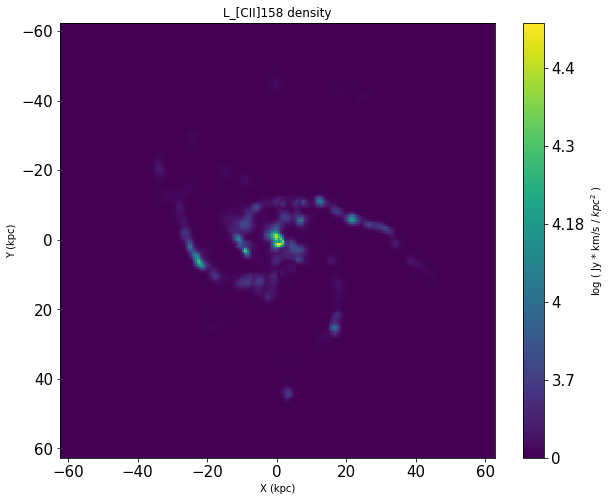

In [29]:
#Plotting: 

ax1,ax2 = momentmap[:, 1], momentmap[:, 2]

nrows, ncols = index1, index2
grid = lum.reshape((nrows, ncols))
grid = np.flip(grid, 0) #grid = np.transpose(grid)
normal = mpl.colors.Normalize(vmin = -max(lum), vmax = max(lum))

if num != 1:
    fig,ax = plt.subplots(figsize=(10,8))

    cs = ax.imshow(grid, extent=(ax1.min(), ax1.max(), ax2.max(), ax2.min()),
               interpolation='nearest', cmap=cm.viridis)
    plt.title(prop + ' density')
    plt.xlabel(plane[0].upper()+' (kpc)')
    plt.ylabel(plane[1].upper()+' (kpc)')
    
    if units == 'yes':
        labels = '$\log$ ( Jy * km/s / $kpc^2$ )'
    else:     
        if num == 0:
            labels = '$\log$ ( $M_\odot$ / $kpc^2$ )'
        else:
            labels = '$\log$ ( $L_\odot$ / $kpc^2$ )'
    formatter = mpl.ticker.LogFormatterExponent(10, labelOnlyBase=False, minor_thresholds=(100,20))
    fig.colorbar(cs, norm = normal, cmap=cm.viridis, label=labels, format=formatter)

    plt.savefig(prop +'.png',dpi=500)
    plt.show()
    
else:
    fig,ax = plt.subplots(figsize=(10,8))

    cs = ax.imshow(grid, extent=(ax1.min(), ax1.max(), ax2.max(), ax2.min()),
               interpolation='nearest', cmap=cm.viridis)
    plt.title(prop + ' density')
    plt.xlabel(plane[0].upper()+' (kpc)')
    plt.ylabel(plane[1].upper()+' (kpc)')
    
    formatter = mpl.ticker.ScalarFormatter()
    fig.colorbar(cs, norm = normal, cmap=cm.viridis, format = formatter)
    plt.savefig(prop +'.png',dpi=500)
    plt.show()

### Total luminosity/mass check:

In [30]:
if num != 1:
    if num == 0 or (num != 0 and units == 'no'):
        print('Total Projected Luminosity/Mass:', sum(lum*(PIXELSIZE**2)))  
        print('Total Luminosity/Mass in the cube:', sum(properties[:, num]))
    else:
        print('Total Projected Luminosity/Mass:', sum(lum*(PIXELSIZE**2) *(1.04e-3 * D**2 * v) / (1+z) ))  
        print('Total Luminosity/Mass in the cube:', sum(properties[:, num]))

Total Projected Luminosity/Mass: 452845100.44462633
Total Luminosity/Mass in the cube: 452845100.44463754
